# 1. Introduction
Gig workers are independent contractors. They are not in a fixed long-term relationship with the organization and they have the ability to set their own hours and move between different platforms easily. Hence, it is important to assess the daily and hourly activity of these drivers, to have an assurance of driver supply and availability in the near future. A year, month or day ahead forecast can help the utilities plan for a larger time scale but for smoother daily operations an hourly (or even better) forecast can prove very useful.

This project will involve analyzing activity of drivers with atleast ~ 2 years of history with the spark app to find trends in Spark On minutes spent around hour of the day, day of the week, season of the year etc. and also to check factors like hiked delivery fees and offer frequency that can impact the driver's willingness to go online. A model can be built to predict the time spent online with given parameters like day of week, time of day etc, season, holiday etc.

In [7]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import scipy.stats
import matplotlib.dates as mdates
from google.cloud import bigquery
from sklearn.metrics import mean_squared_error

# 2. Data

The table I extracted data from is a join between DRVR_APPLN_ACTV and DRVR. For the purpose of this project, I will be using data pertaining to only the Orlando region (has much data and diverse drivers) to study driver activity. To start off, we will be looking at a univariate analysis of minutes spent online during every hour for the past 2 years and then move on to a multivariate analysis on how other factors could be influencing the drivers. The most important attributes we require are DRVR_USER_ID, DRVR_ACTV_IND, ACTV_START_TS, ACTL_ACTV_END_TS, **ACTV_DUR_MIN_QTY**. The given data is a collection of irregular activity timestamps that are scattered randomly between minutes, hours and days. But for our project, we need a uniform timeline of every hour in the selected period of time and the value of number of minutes spent online during each of these slot hours.

In [8]:
#connecting notebook to gcloud bigquery to query data.
cred_file = r"C:\Users\V0V01S7\AppData\Roaming\gcloud\legacy_credentials\venkatasaiyashaswi.v@walmart.com\adc.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=cred_file
def query_bq(QUERY):
    client = bigquery.Client(project='wmt-edw-sandbox')
    query_job = client.query(QUERY) # API request
    rows = query_job.result() # Waits for query to finish
    df = rows.to_dataframe()
    return df

In [9]:
# choose driver name for forecasting later
code = """select A.DRVR_USER_ID, 
B.ACTV_START_TS, B.ACTL_ACTV_END_TS, B.ACTV_DUR_MIN_QTY, B.ACTV_DT, 
from `wmt-edw-prod.WW_GEC_VM.DRVR` A inner join `wmt-edw-prod.WW_GEC_VM.DRVR_APPLN_ACTV` B on A.DRVR_USER_ID = B.DRVR_USER_ID
where A.MARKET_NM = 'Walmart San Jose North' AND B.ACTV_NM = "ONLINE"
"""
df = query_bq(code)
df["ACTV_START_TS"] = pd.to_datetime(df["ACTV_START_TS"])
df["ACTL_ACTV_END_TS"] = pd.to_datetime(df["ACTL_ACTV_END_TS"])
#df["ACTV_START_TS"] = df["ACTV_START_TS"] + pd.Timedelta(hours=3) #converting pacific time to eastern time (orlando market)
#df["ACTL_ACTV_END_TS"] = df["ACTL_ACTV_END_TS"] + pd.Timedelta(hours=3)
df["DRVR_USER_ID"].value_counts().nlargest(n=10)

iphoneskyper@gmail.com          723
glocesaga@hotmail.com           704
rodriguezriverajc@gmail.com     624
vargasefrain.123@gmail.com      507
manuelsandoval1976@yahoo.com    504
eddielara90@yahoo.com           446
tleipelt@ymail.com              425
thairymartinez8@gmail.com       422
jim@stanley.net                 420
joowpublicidade@gmail.com       405
Name: DRVR_USER_ID, dtype: int64

Let's look at the top 100 drivers (having more data) to analyze the most active driver by slot hour

In [10]:
dfs = {}
for ID in df['DRVR_USER_ID'].value_counts()[0:100].index.tolist():
    dfs[ID] = df.loc[df['DRVR_USER_ID'] == ID]

In [11]:
def final(df):
    df['dayhour'] = df["ACTV_START_TS"].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
    time_line = pd.date_range(df["dayhour"].min(),df["dayhour"].max(),freq='H')
    time_line = time_line.to_series()
    ts = pd.DataFrame(time_line,columns = ["dayhour"])
    ts = ts.set_index("dayhour")
    ts = pd.merge(ts,df,how="left",on=["dayhour"])
    ts["ACTV_DUR_MIN_QTY"] = ts["ACTV_DUR_MIN_QTY"].fillna(0)
    ts = ts.drop(["DRVR_USER_ID","ACTV_DT"],axis=1)
    ts = ts.set_index(["dayhour"],drop=True)
    ts = ts.drop_duplicates()
    ts = ts.dropna()
    ts = ts.reset_index(drop=False)
    ts['ACTV_START_TS'] = ts["ACTV_START_TS"].apply(lambda x: x.replace(second=0, microsecond=0))
    ts['ACTL_ACTV_END_TS'] = ts["ACTL_ACTV_END_TS"].apply(lambda x: x.replace(second=0, microsecond=0))
    def create_final_data(df):
        df['minutes'] = (df['ACTL_ACTV_END_TS'] - df['ACTV_START_TS']).dt.total_seconds()/60
        df = df[df['minutes']>0].reset_index(drop=True)
        # create an IntervalIndex which we can set as the axis (needed for re-indexing).
        # subtract one minute from end_time so that the minute of the termination is excluded.
        iv_idx = pd.IntervalIndex.from_arrays(df['ACTV_START_TS'],
                                              df['ACTL_ACTV_END_TS']-pd.Timedelta(minutes=1),
                                              closed='both')
        # create a new index with the extended frequency:
        new_idx = pd.date_range(df['ACTV_START_TS'].min(), df['ACTL_ACTV_END_TS'].max(), freq='min')
        # set the new index to get the extended frequency;
        # all minutes will have the value of the whole interval
        result = df['minutes'].set_axis(iv_idx).reindex(new_idx)
        # we can now calculate the duration per hour by resampling and summing the
        # boolean representation of the duration (1/0):
        result= result.fillna(0).astype(int).astype(bool).resample('H').sum()
        result.index.name = 'start_hour'
        return result
    re = create_final_data(ts)
    re = pd.DataFrame(re)
    def create_features(df, label=None):
        """
        Creates time series features from datetime index.
        """
        df = df.copy()
        df['date'] = df.index
        df['hour'] = df['date'].dt.hour
        df['dayofweek'] = df['date'].dt.dayofweek
        df['quarter'] = df['date'].dt.quarter
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        df['dayofyear'] = df['date'].dt.dayofyear
        df['dayofmonth'] = df['date'].dt.day
        df['weekofyear'] = df['date'].dt.weekofyear

        X = df[['hour','dayofweek','quarter','month','year',
               'dayofyear','dayofmonth','weekofyear']]
        if label:
            y = df[label]
            return X, y
        return X

    X, y = create_features(re, label='minutes')

    ft = pd.concat([X, y], axis=1)
    
    hour_weekday = ft.pivot_table(values='minutes', index='hour', columns = 'dayofweek', aggfunc = 'mean')
    
    return hour_weekday

In [59]:
# example of how each pivot table for a given driver looks like
dfs['iphoneskyper@gmail.com']

,DRVR_USER_ID,ACTV_START_TS,ACTL_ACTV_END_TS,ACTV_DUR_MIN_QTY,ACTV_DT,dayhour
288,iphoneskyper@gmail.com,2022-04-12 08:56:13.324,2022-04-12 09:13:39.267,17.430000000,2022-04-12,2022-04-12 08:00:00
289,iphoneskyper@gmail.com,2022-04-12 09:13:39.267,2022-04-12 10:29:35.401,75.930000000,2022-04-12,2022-04-12 09:00:00
290,iphoneskyper@gmail.com,2022-04-12 10:29:35.401,2022-04-12 10:32:55.147,3.330000000,2022-04-12,2022-04-12 10:00:00
291,iphoneskyper@gmail.com,2022-04-12 10:35:50.129,2022-04-12 10:37:12.728,1.370000000,2022-04-12,2022-04-12 10:00:00
292,iphoneskyper@gmail.com,2022-04-12 10:37:12.728,2022-04-12 10:39:46.277,2.570000000,2022-04-12,2022-04-12 10:00:00
...,...,...,...,...,...,...
17061,iphoneskyper@gmail.com,2022-06-28 11:19:46.694,2022-06-28 11:27:58.070,8.200000000,2022-06-28,2022-06-28 11:00:00
17062,iphoneskyper@gmail.com,2022-06-28 11:27:58.070,2022-06-28 11:29:02.785,1.070000000,2022-06-28,2022-06-28 11:00:00
17063,iphoneskyper@gmail.com,2022-06-28 11:29:02.785,2022-06-28 11:29:57.837,0.920000000,2022-06-28,2022-06-28 11:00:00
17064,iphoneskyper@gmail.com,2022-06-28 12:19:50.251,2022-06-28 12:23:55.921,4.080000000,2022-06-28,2022-06-28 12:00:00


In [17]:
# creating a set of top 100 drivers and their pivot tables
dfs_set = {}
for i in dfs.keys():
    dfs_set[i] = pd.DataFrame(final(dfs[i]))
    dfs_set[i]["ID"] = i

In [18]:
dff = pd.concat([dfs_set[i] for i in dfs_set.keys()], ignore_index=False)

In [19]:
dff.shape

(2400, 8)

In [20]:
dffn = dff.to_numpy()
dffn = dffn.reshape(100,24,8)
zv = np.argmax(dffn[:,:,:7],axis=0)
zv.shape

(24, 7)

In [58]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Heatmap(
                   z=zv,
                   x=list(range(1,7)),
                   y=list(range(1,24)),
                   hoverongaps = False))
fig.update_layout(title="Most Active Driver for slot-hour",
                  yaxis={"title": 'Hour of the day'},
                  xaxis={"title": 'Day of week'},
                  yaxis_nticks=24,
                 height = 500,
                 width = 700)

fig.show()

driver should be given the order first

## Individual driver analysis

Let us study the activity of any individual driver to set up our forecasting model. It is important to check the weekly trend and study the impact of exogenous variables

In [60]:
def final_ft(df):
    df['dayhour'] = df["ACTV_START_TS"].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
    time_line = pd.date_range(df["dayhour"].min(),df["dayhour"].max(),freq='H')
    time_line = time_line.to_series()
    ts = pd.DataFrame(time_line,columns = ["dayhour"])
    ts = ts.set_index("dayhour")
    ts = pd.merge(ts,df,how="left",on=["dayhour"])
    ts["ACTV_DUR_MIN_QTY"] = ts["ACTV_DUR_MIN_QTY"].fillna(0)
    ts = ts.drop(["DRVR_USER_ID","ACTV_DT"],axis=1)
    ts = ts.set_index(["dayhour"],drop=True)
    ts = ts.drop_duplicates()
    ts = ts.dropna()
    ts = ts.reset_index(drop=False)
    ts['ACTV_START_TS'] = ts["ACTV_START_TS"].apply(lambda x: x.replace(second=0, microsecond=0))
    ts['ACTL_ACTV_END_TS'] = ts["ACTL_ACTV_END_TS"].apply(lambda x: x.replace(second=0, microsecond=0))
    def create_final_data(df):
        df['minutes'] = (df['ACTL_ACTV_END_TS'] - df['ACTV_START_TS']).dt.total_seconds()/60
        df = df[df['minutes']>0].reset_index(drop=True)
        # create an IntervalIndex which we can set as the axis (needed for re-indexing).
        # subtract one minute from end_time so that the minute of the termination is excluded.
        iv_idx = pd.IntervalIndex.from_arrays(df['ACTV_START_TS'],
                                              df['ACTL_ACTV_END_TS']-pd.Timedelta(minutes=1),
                                              closed='both')
        # create a new index with the extended frequency:
        new_idx = pd.date_range(df['ACTV_START_TS'].min(), df['ACTL_ACTV_END_TS'].max(), freq='min')
        # set the new index to get the extended frequency;
        # all minutes will have the value of the whole interval
        result = df['minutes'].set_axis(iv_idx).reindex(new_idx)
        # we can now calculate the duration per hour by resampling and summing the
        # boolean representation of the duration (1/0):
        result= result.fillna(0).astype(int).astype(bool).resample('H').sum()
        result.index.name = 'start_hour'
        return result
    re = create_final_data(ts)
    re = pd.DataFrame(re)
    def create_features(df, label=None):
        """
        Creates time series features from datetime index.
        """
        df = df.copy()
        df['date'] = df.index
        df['hour'] = df['date'].dt.hour
        df['dayofweek'] = df['date'].dt.dayofweek
        df['quarter'] = df['date'].dt.quarter
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        df['dayofyear'] = df['date'].dt.dayofyear
        df['dayofmonth'] = df['date'].dt.day
        df['weekofyear'] = df['date'].dt.isocalendar().week

        X = df[['hour','dayofweek','quarter','month','year',
               'dayofyear','dayofmonth','weekofyear']]
        if label:
            y = df[label]
            return X, y
        return X

    X, y = create_features(re, label='minutes')

    ft = pd.concat([X, y], axis=1)
    return ft

In [61]:
dfl = df.loc[df["DRVR_USER_ID"] == "iphoneskyper@gmail.com"]
ft = final_ft(dfl)
ft.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,minutes
start_hour,,,,,,,,,
2022-03-29 07:00:00,7,1,1,3,2022,88,29,13,18
2022-03-29 08:00:00,8,1,1,3,2022,88,29,13,29
2022-03-29 09:00:00,9,1,1,3,2022,88,29,13,42
2022-03-29 10:00:00,10,1,1,3,2022,88,29,13,47
2022-03-29 11:00:00,11,1,1,3,2022,88,29,13,22


In [24]:
import seaborn as sns

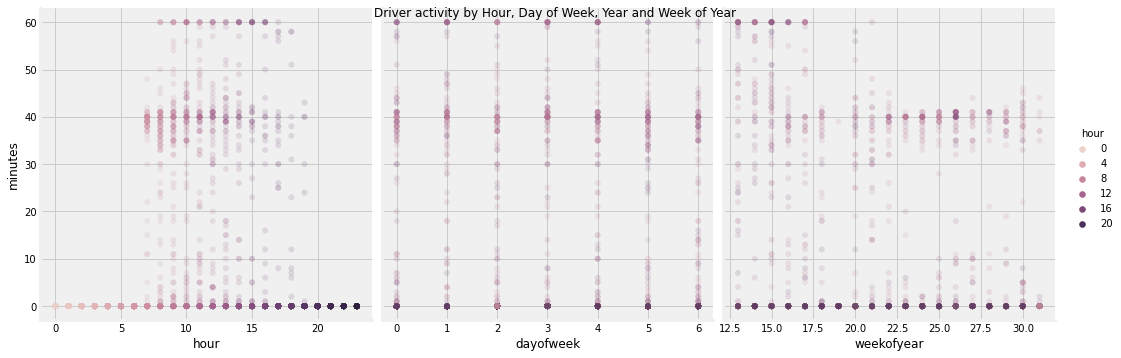

In [25]:
g = sns.pairplot(ft,
             hue='hour',
             x_vars=['hour','dayofweek',
                     'weekofyear'],
             y_vars='minutes',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )

plt.suptitle('Driver activity by Hour, Day of Week, Year and Week of Year')
plt.show()

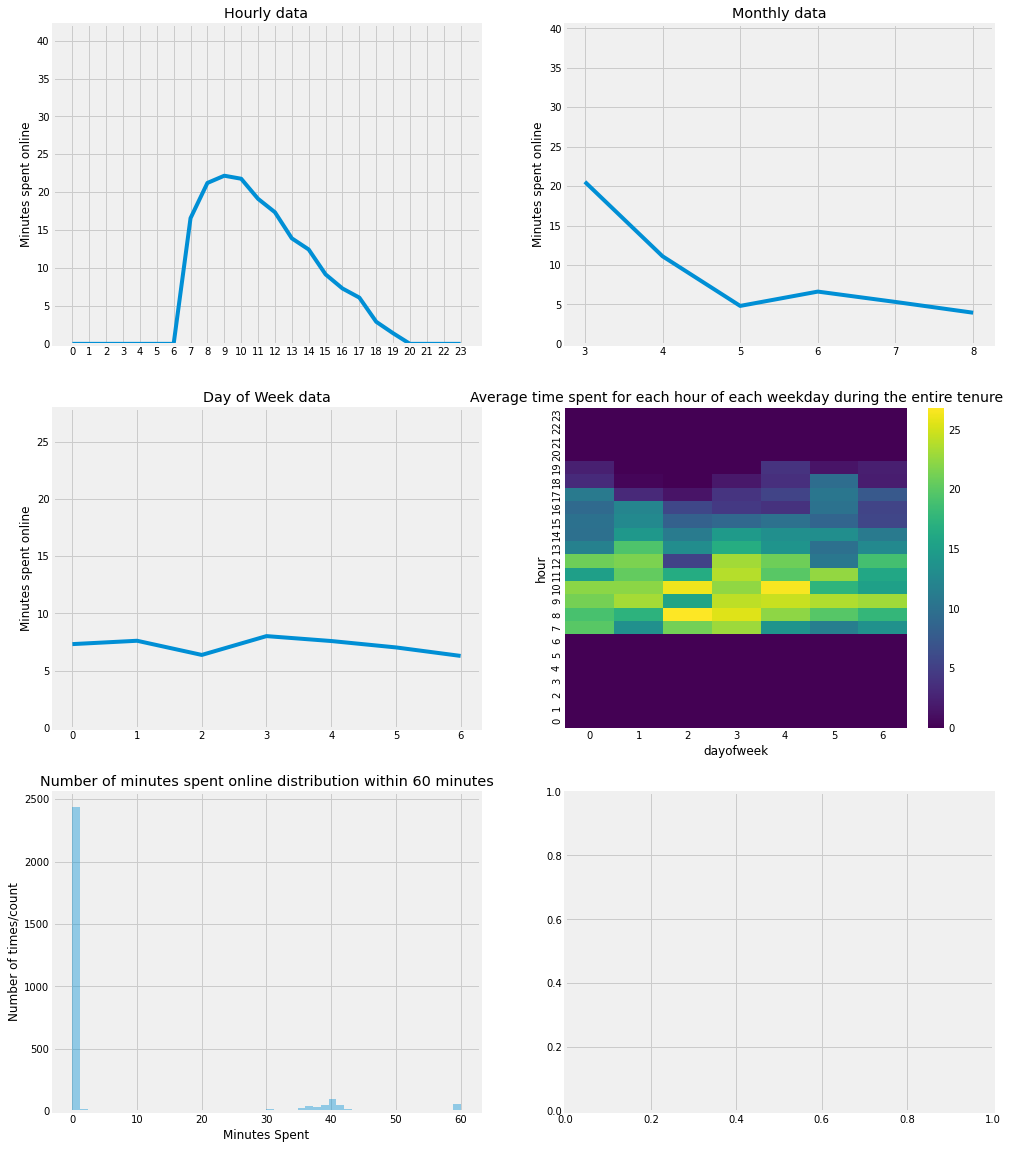

In [62]:
fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(3,2, figsize=(15,20))
ax1.plot(ft.groupby('hour')['minutes'].mean())
ax1.set_ylabel('Minutes spent online')
ax1.set_ylim([0, max(ft.groupby('hour')['minutes'].mean() + 20 )])
ax1.set_xticks(ft['hour'].unique())
ax1.set_title('Hourly data')

ax2.plot(ft.groupby('month')['minutes'].mean())
ax2.set_ylabel('Minutes spent online')
ax2.set_ylim([0, max(ft.groupby('month')['minutes'].mean() + 20 )])
ax2.set_xticks(ft['month'].unique())
ax2.set_title('Monthly data')

ax3.plot(ft.groupby('dayofweek')['minutes'].mean())
ax3.set_ylabel('Minutes spent online')
ax3.set_ylim([0, max(ft.groupby('dayofweek')['minutes'].mean() + 20 )])
ax3.set_xticks(ft['dayofweek'].unique())
ax3.set_title('Day of Week data')

sns.heatmap(final(dfl).sort_index(ascending = False), cmap='viridis', ax = ax4)
ax4.set_title("Average time spent for each hour of each weekday during the entire tenure", fontsize = 14)

sns.distplot(ft['minutes'], kde=False, ax=ax5)
ax5.set_title('Number of minutes spent online distribution within 60 minutes')
ax5.set_xlabel('Minutes Spent')
ax5.set_ylabel('Number of times/count')

plt.show()

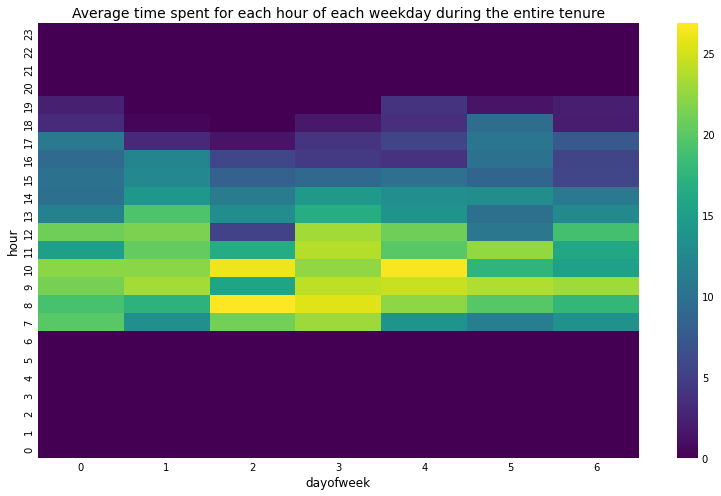

In [57]:
_ = plt.figure(figsize=(12, 8))
ax = sns.heatmap(final(dfl).sort_index(ascending = False), cmap='viridis')
_ = ax.set_title("Average time spent for each hour of each weekday during the entire tenure", fontsize = 14)

# Time Series Forecasting

In [90]:
re = pd.DataFrame(ft.minutes)
re.head()

,minutes
start_hour,
2021-08-11 07:00:00,14
2021-08-11 08:00:00,60
2021-08-11 09:00:00,60
2021-08-11 10:00:00,60
2021-08-11 11:00:00,0


In [91]:
re = re["2021-08-12 00:00:00":]

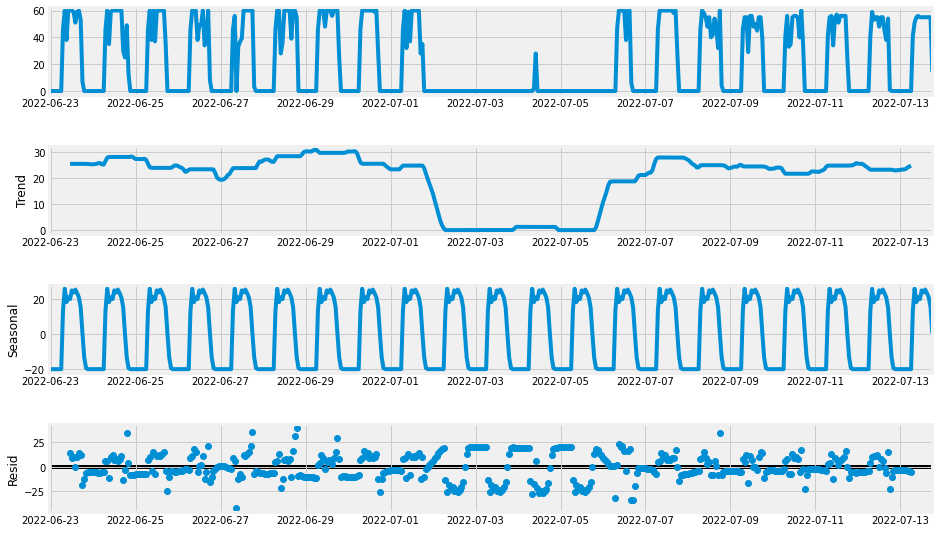

In [92]:
res = seasonal_decompose(re.tail(500))
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [93]:
split_date = '01-Jul-2022'
ts_train = re.loc[re.index <= split_date].copy()
ts_test = re.loc[re.index > split_date].copy()
tr_start,tr_end = ts_train.index[0],ts_train.index[-1]
te_start,te_end = ts_test.index[0],ts_test.index[-1]

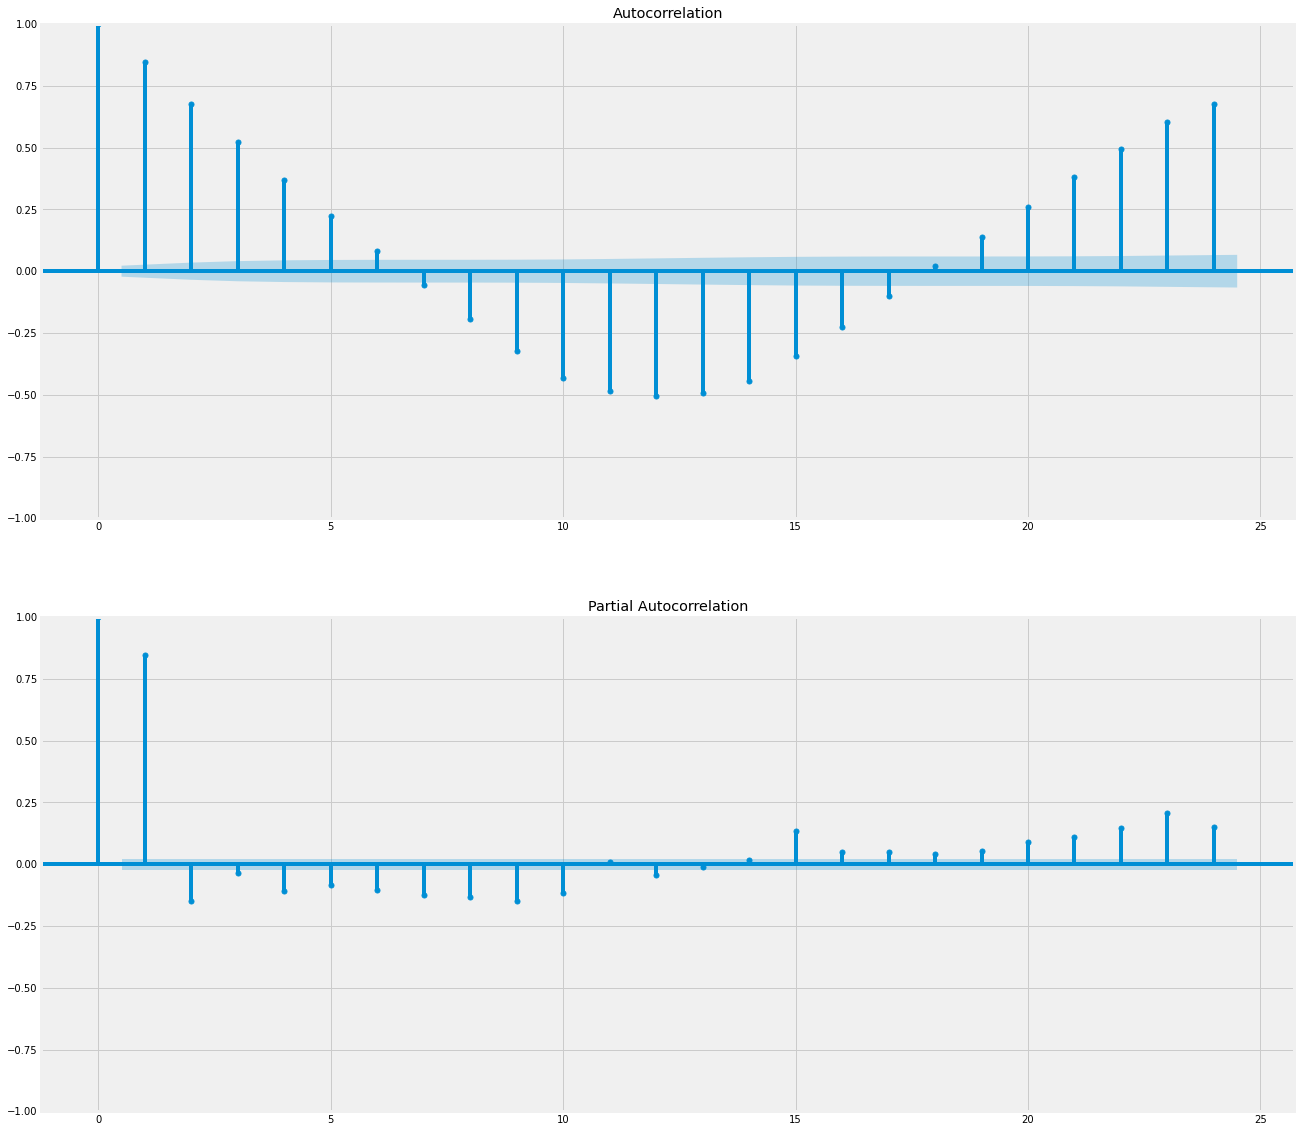

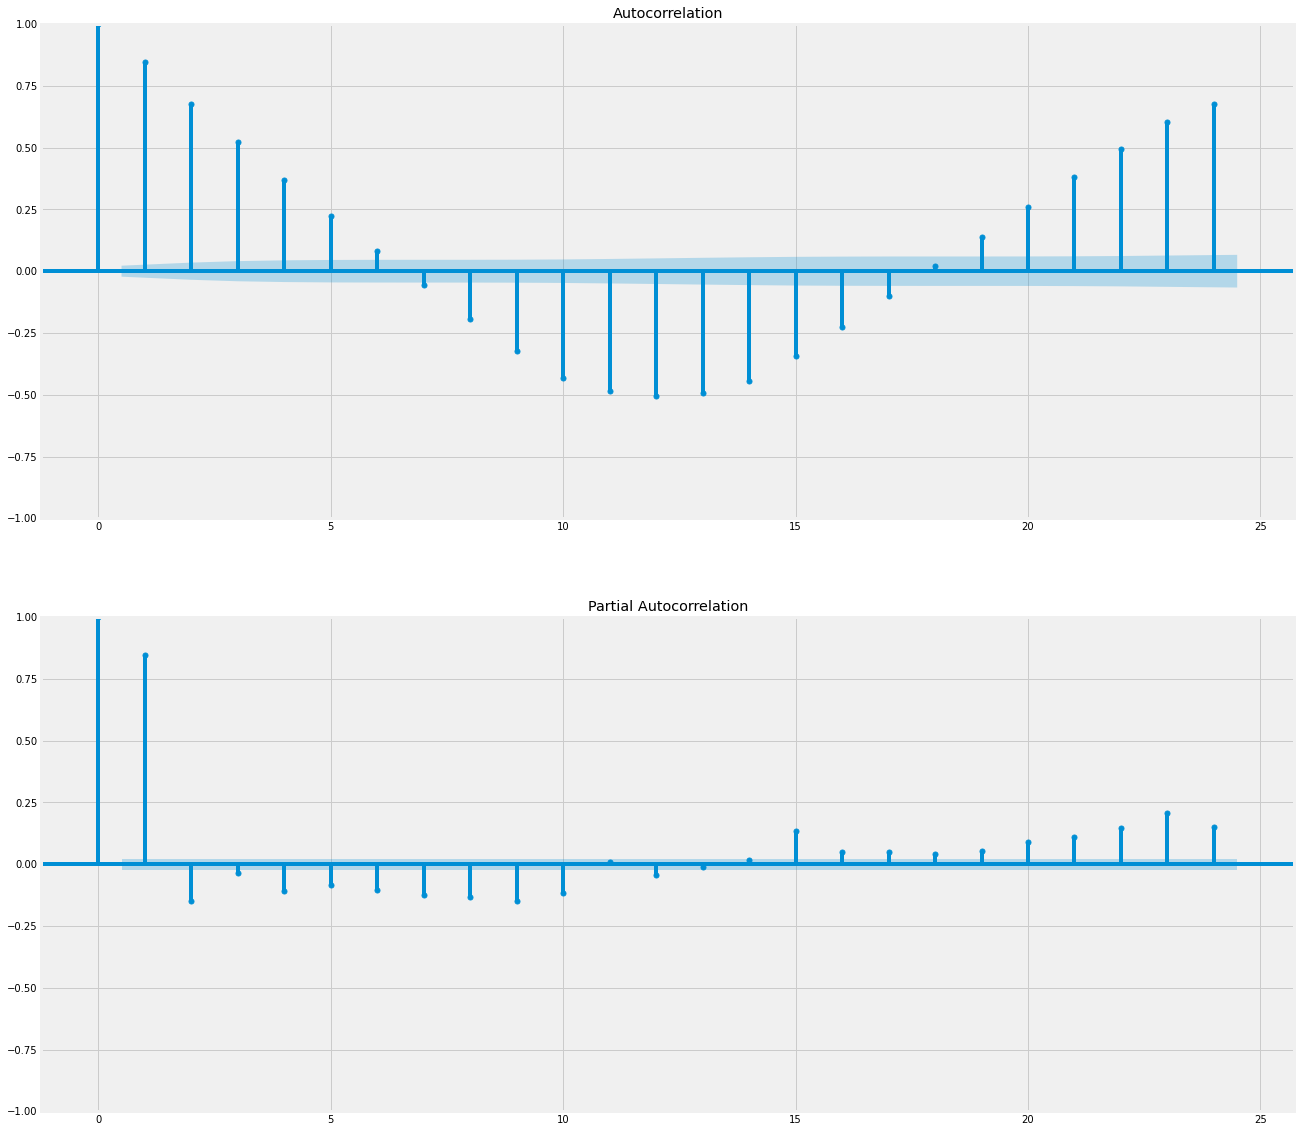

In [94]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(20, 20))

plot_acf(ts_train, lags = 24, ax = ax1)
plot_pacf(ts_train, lags = 24, ax = ax2)

In [95]:
arima = sm.tsa.statespace.SARIMAX(ts_train,order=(1,0,1),freq='H',seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                minutes   No. Observations:                 7753
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -31627.729
Date:                Wed, 13 Jul 2022   AIC                          63261.459
Time:                        17:59:02   BIC                          63282.325
Sample:                    08-12-2021   HQIC                         63268.612
                         - 07-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8760      0.006    152.888      0.000       0.865       0.887
ma.L1          0.1308      0.012     11.286      0.000       0.108       0.154
sigma2       205.1091      1.726    118.839      0.000     201.726     208.492
===================================================================================
Ljung-Box (L1) (Q):                   4.11   Jarque-Bera (JB):             16872.64
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             0.60
Prob(H) (two-sided):                  0.01   Kurtosis:                        10.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [96]:
pred = arima.predict(tr_end,te_end)[1:]
print('ARIMA model MSE:{}'.format(mean_squared_error(ts_test,pred)))

ARIMA model MSE:895.3202752256359


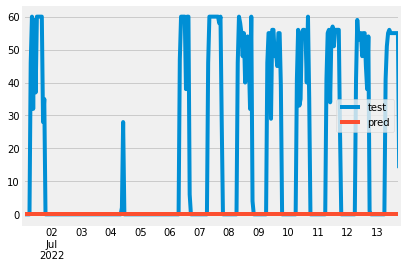

In [97]:
pred = pd.DataFrame(pred)
pd.DataFrame({'test':ts_test.minutes,'pred':pred.predicted_mean}).plot()
plt.show()

In [103]:
ft

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,minutes
start_hour,,,,,,,,,
2021-08-11 07:00:00,7,2,3,8,2021,223,11,32,14
2021-08-11 08:00:00,8,2,3,8,2021,223,11,32,60
2021-08-11 09:00:00,9,2,3,8,2021,223,11,32,60
2021-08-11 10:00:00,10,2,3,8,2021,223,11,32,60
2021-08-11 11:00:00,11,2,3,8,2021,223,11,32,0
...,...,...,...,...,...,...,...,...,...
2022-07-13 14:00:00,14,2,3,7,2022,194,13,28,55
2022-07-13 15:00:00,15,2,3,7,2022,194,13,28,55
2022-07-13 16:00:00,16,2,3,7,2022,194,13,28,55


In [227]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(ft[['dayofweek']]).toarray())


#merge one-hot encoded columns back with original DataFrame
final_df = ft.join(encoder_df)

#view final df
final_df.columns = ["hour","dayofweek","quarter","month","year","dayofyear","dayofmonth","weekofyear","minutes","monday","tuesday","wednesday","thursday","friday","saturday","sunday"]
final_df = final_df.fillna(0)
final_df.tail()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,minutes,monday,tuesday,wednesday,thursday,friday,saturday,sunday
start_hour,,,,,,,,,,,,,,,,
2022-07-13 14:00:00,14,2,3,7,2022,194,13,28,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-13 15:00:00,15,2,3,7,2022,194,13,28,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-13 16:00:00,16,2,3,7,2022,194,13,28,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-13 17:00:00,17,2,3,7,2022,194,13,28,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-13 18:00:00,18,2,3,7,2022,194,13,28,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [228]:
encoder_df["dayhour"] = ft.index
encoder_df = encoder_df.set_index("dayhour",drop=True)
encoder_df

,0,1,2,3,4,5,6
dayhour,,,,,,,
2021-08-11 07:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-08-11 08:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-08-11 09:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-08-11 10:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-08-11 11:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2022-07-13 14:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-07-13 15:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-07-13 16:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [229]:
final_df = ft.join(encoder_df)
final_df
final_df.columns = ["hour","dayofweek","quarter","month","year","dayofyear","dayofmonth","weekofyear","minutes","monday","tuesday","wednesday","thursday","friday","saturday","sunday"]
final_df

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,minutes,monday,tuesday,wednesday,thursday,friday,saturday,sunday
start_hour,,,,,,,,,,,,,,,,
2021-08-11 07:00:00,7,2,3,8,2021,223,11,32,14,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-08-11 08:00:00,8,2,3,8,2021,223,11,32,60,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-08-11 09:00:00,9,2,3,8,2021,223,11,32,60,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-08-11 10:00:00,10,2,3,8,2021,223,11,32,60,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-08-11 11:00:00,11,2,3,8,2021,223,11,32,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-13 14:00:00,14,2,3,7,2022,194,13,28,55,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-07-13 15:00:00,15,2,3,7,2022,194,13,28,55,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-07-13 16:00:00,16,2,3,7,2022,194,13,28,55,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [188]:
sarima = sm.tsa.statespace.SARIMAX(ft[:tr_end].minutes,exog = final_df[:tr_end][["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]], order=(1,0,1),seasonal_order=(1,0,1,24),
                                enforce_stationarity=False, enforce_invertibility=False,freq='H').fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            minutes   No. Observations:                 7770
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -29312.492
Date:                            Thu, 14 Jul 2022   AIC                          58648.985
Time:                                    11:02:44   BIC                          58732.441
Sample:                                08-11-2021   HQIC                         58677.597
                                     - 07-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
monday        19.3508     14.763      1.311      0.190      -9.583      48.285
tuesday       21.8582     14.773      1.480      0.139      -7.097      50.813
wednesday     23.0640     14.785      1.560      0.119      -5.915      52.043
thursday      22.9713     14.795      1.553      0.121      -6.026      51.969
friday        20.5725     14.873      1.383      0.167      -8.578      49.723
saturday      14.8007     14.794      1.000      0.317     -14.196      43.797
sunday        13.7371     14.846      0.925      0.355     -15.360      42.835
ar.L1          0.7367      0.009     84.408      0.000       0.720       0.754
ma.L1          0.0648      0.011      5.679      0.000       0.042       0.087
ar.S.L24       0.9986      0.000   3114.749      0.000       0.998       0.999
ma.S.L24      -0.9677      0.002   -460.519      0.000      -0.972      -0.964
sigma2       112.6137      1.193     94.386      0.000     110.275     114.952
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             14210.34
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -1.05
Prob(H) (two-sided):                  0.31   Kurtosis:                         9.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [189]:
exog_forecast = final_df[te_start:te_end][["monday","tuesday","wednesday","thursday","friday","saturday","sunday"]]
pred_s = sarima.predict(tr_end,te_end, exog = exog_forecast)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(ts_test,pred_s)))

SARIMA model MSE:311.75866904424237


In [197]:
print('SARIMA model MSE:{}'.format(mean_squared_error(ts_test,pred_s)))

SARIMA model MSE:309.0046364566022


In [199]:
math.sqrt(309)

17.578395831246947

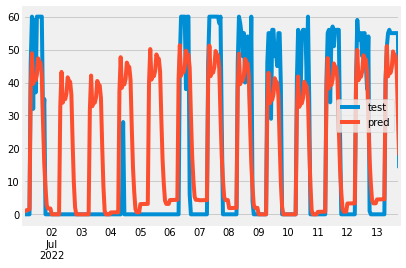

In [194]:
pred_s = pd.DataFrame(pred_s)
pd.DataFrame({'test':ts_test.tail(500).minutes,'pred':pred_s.tail(500).predicted_mean}).plot()
plt.show()

In [193]:
pred_s[pred_s.predicted_mean < 0] = 0
pred_s

,predicted_mean
2022-07-01 01:00:00,0.560026
2022-07-01 02:00:00,0.878697
2022-07-01 03:00:00,1.113466
2022-07-01 04:00:00,1.286425
2022-07-01 05:00:00,1.413847
...,...
2022-07-13 14:00:00,48.442059
2022-07-13 15:00:00,48.076187
2022-07-13 16:00:00,44.270336
2022-07-13 17:00:00,30.044941


In [196]:
pred_s.to_csv("Desktop/pred_s.csv")
ts_test.to_csv("Desktop/ts_test.csv")